In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *
import umap 

In [13]:
df = pd.read_csv(vcf_path+"/GenotypeCounts.csv")
df.drop(columns=['patient_id'],inplace=True)  
#,'IL10RA','RELA','TAGAP','PTAFR','IL23R','SDF2L1','PTPN22','SLC39A8','HGFAC','DOK2','CCR7'
labels = df['label']

In [3]:
df

,ATG16L1,NOD2,PTPN22,LACC1,IL23R,SLC39A8,CARD9,FUT2,PTAFR,HGFAC,TAGAP,DOK2,RELA,IL10RA,CCR7,SDF2L1,label
0,2,1,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,1
2,1,0,2,1,0,0,0,2,0,0,0,0,0,0,0,0,1
3,1,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0
4,2,0,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
107,0,0,2,0,1,1,0,0,0,0,0,1,0,0,0,1,1
108,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0
109,0,0,2,2,0,0,2,1,0,0,0,0,0,0,1,0,1


In [4]:
df=df.sample(frac=1, random_state=42).reset_index(drop=True)

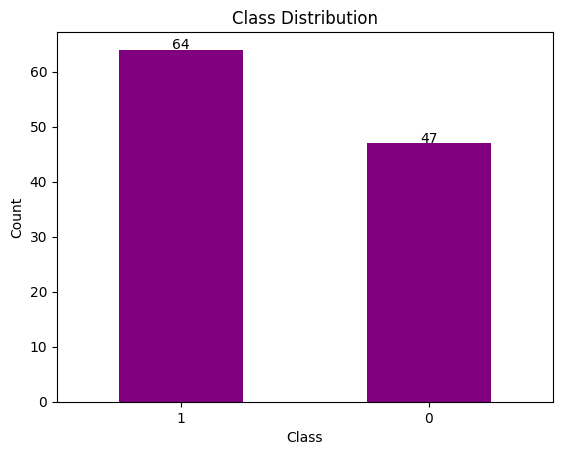

In [95]:
class_counts = df['label'].value_counts()
ax = class_counts.plot(kind='bar', color='purple', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, count in enumerate(class_counts):
    ax.text(i, count + 0.1, str(count), ha='center')
plt.show()

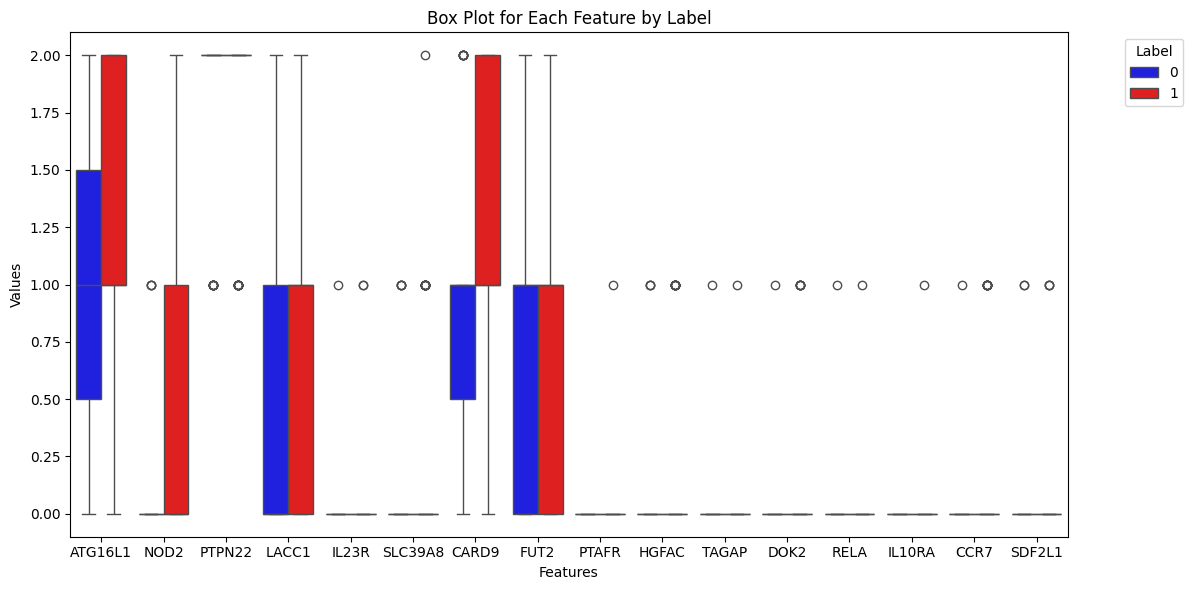

In [168]:
df_melted = df.melt(id_vars='label', var_name='Feature', value_name='Value')
palette = {0: 'blue', 1: 'red'}
plt.figure(figsize=(12, 6))  # Adjust figure size here
sns.boxplot(x='Feature', y='Value', hue='label', data=df_melted, palette=palette)
plt.title('Box Plot for Each Feature by Label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

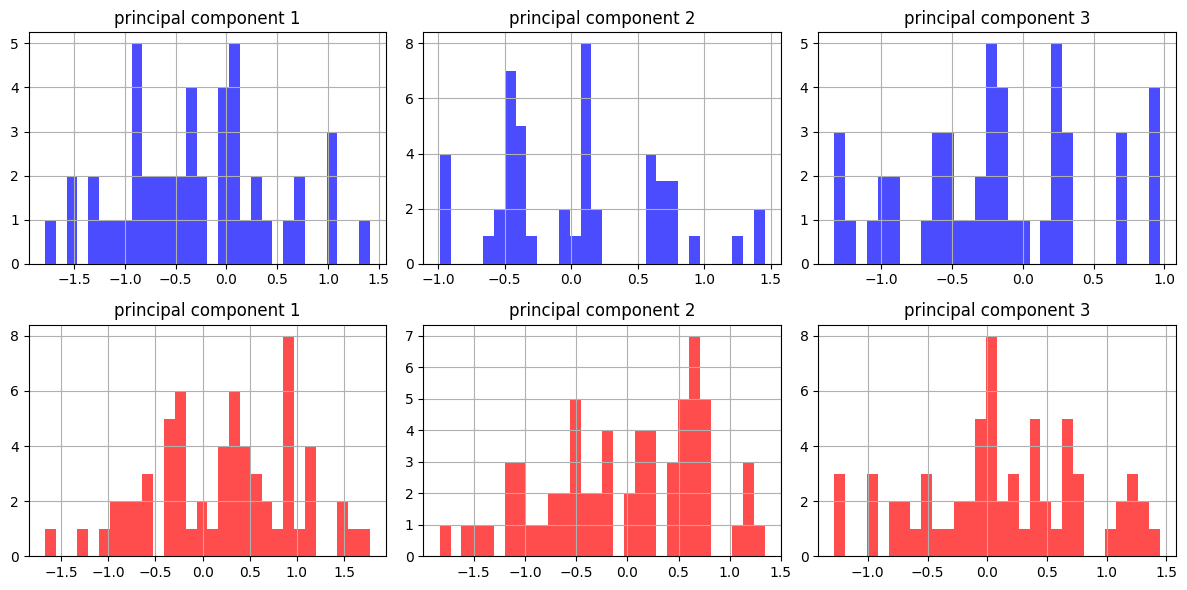

In [149]:
# Filter the DataFrame for label == 0 and label == 1
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot histogram for label 0
df_label_0.drop('label', axis=1).hist(bins=30, color='blue', alpha=0.7, ax=axes[0])
# Plot histogram for label 1
df_label_1.drop('label', axis=1).hist(bins=30, color='red', alpha=0.7, ax=axes[1])
# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
outliers = {}
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
print("Outliers detected:")
for feature, outlier_values in outliers.items():
    if not outlier_values.empty:
        print(f"{feature}: {outlier_values.tolist()}")
    else:
        print(f"{feature}: No outliers")

In [ ]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


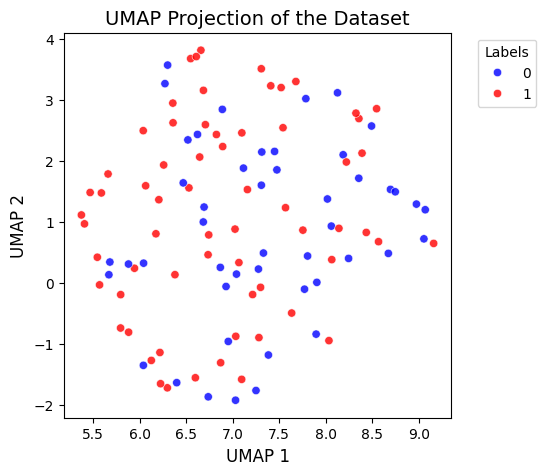

In [169]:
label = df['label']
reducer = umap.UMAP(metric='euclidean')
embedding = reducer.fit_transform(df.drop(columns=['label']))  # Drop the label column before fitting
plt.figure(figsize=(5, 5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, palette=palette, alpha=0.8)
plt.title('UMAP Projection of the Dataset', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


splitting

In [133]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['label'])  # Features (independent variables)
y = df['label']  # Target variable (dependent variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 2), Testing set size: (23, 2)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

logistic regression

Accuracy: 60.8696

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.62      0.77      0.69        13

    accuracy                           0.61        23
   macro avg       0.60      0.58      0.58        23
weighted avg       0.60      0.61      0.59        23



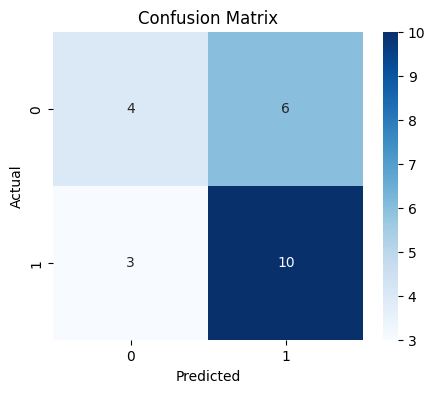

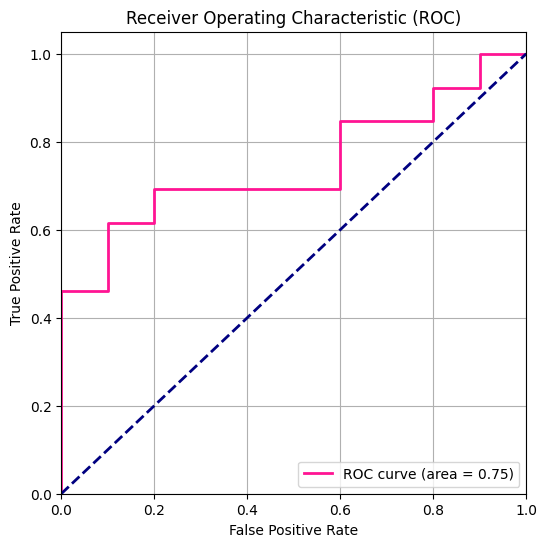

In [160]:
# Initialize and train logistic regression model
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)
# Make predictions
y_pred = logistic.predict(X_test)
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.4f}")
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logistic.classes_, yticklabels=logistic.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_probs = logistic.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


svm

Accuracy: 73.9130

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.73      0.85      0.79        13

    accuracy                           0.74        23
   macro avg       0.74      0.72      0.73        23
weighted avg       0.74      0.74      0.73        23



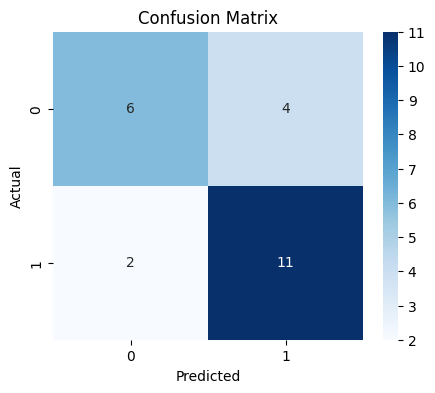

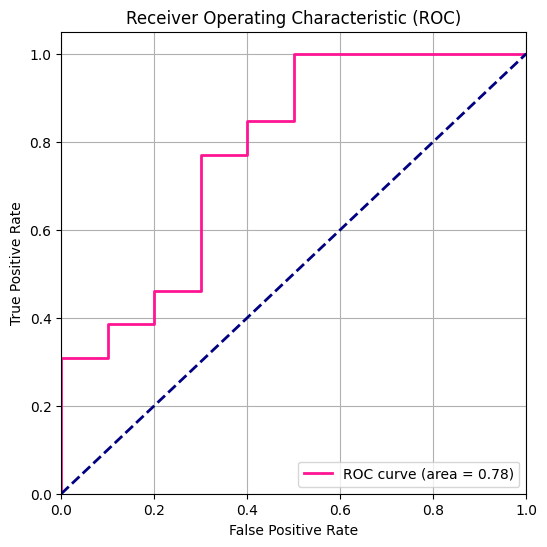

In [161]:
svm_model = SVC( kernel='rbf', C=100, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
# Make predictions
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


y_probs = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

randomForest

In [162]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300, 500],  # Number of trees
    "max_depth": [5, 10, 20, None],  # Depth of trees
    "max_features": ["sqrt", "log2", None],  # Number of features to consider
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4, 10],  # Minimum samples in a leaf
}
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of different combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)
# Fit the model on training data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.6s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimato

Accuracy: 78.2609

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.75      0.92      0.83        13

    accuracy                           0.78        23
   macro avg       0.80      0.76      0.77        23
weighted avg       0.80      0.78      0.77        23



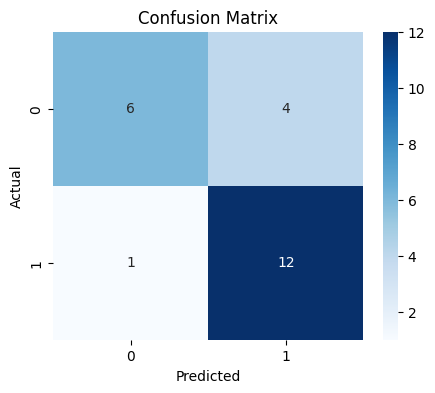

ROC AUC: 0.8077


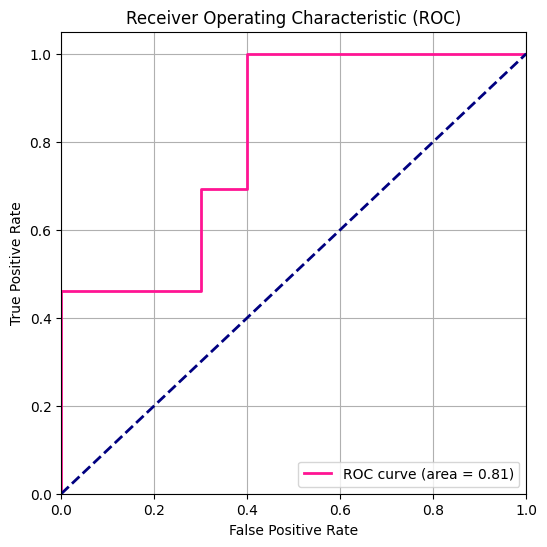

In [ ]:
rf_model = RandomForestClassifier(
    max_depth=None, 
    max_features='log2', 
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=300, 
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Plot ROC curve
y_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Top Genes Contributing to the Model:

      Gene  Importance
1     NOD2    0.215804
0  ATG16L1    0.149670
6     FUT2    0.141931
5    CARD9    0.141067
3    LACC1    0.096629
9     CCR7    0.082788
7    HGFAC    0.068324
2   PTPN22    0.053038
4  SLC39A8    0.049669
8     DOK2    0.001080


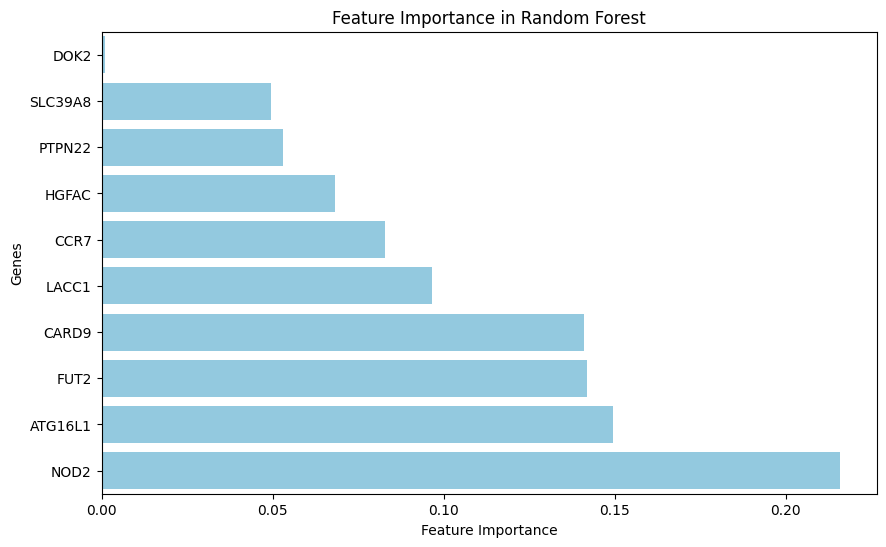

In [68]:
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({"Gene": X.columns, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Print top features
print("\nTop Genes Contributing to the Model:\n")
print(feature_importance_df.head(10))  # Show the top 10 most important genes

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importance_df["Gene"], x=feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Genes")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

PCA

In [14]:
colors = df['label'].map({0: 'blue', 1: 'red'})

In [15]:
from sklearn.decomposition import PCA
pca_df2= PCA(n_components=2)
pca_newpts2 = pca_df2.fit_transform(df)
df = pd.DataFrame(data = pca_newpts2
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variability per principal component: {}'.format(pca_df2.explained_variance_ratio_))

Explained variability per principal component: [0.20298327 0.16460491]


/tmp/ipykernel_310535/3124039630.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(),


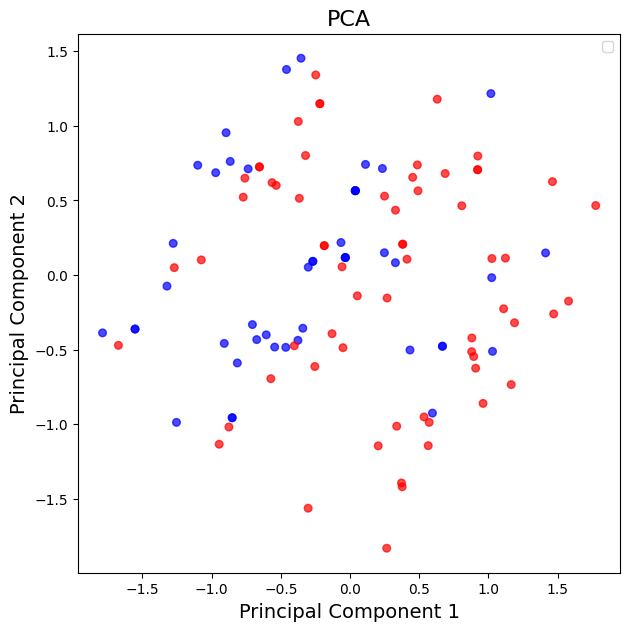

In [6]:
plt.figure(figsize=(7, 7))
plt.scatter(df['principal component 1'],df['principal component 2'],c =colors, s=30, alpha=0.7)

# Adding titles and labels
plt.title('PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(),
# Show the plot
plt.show()

In [18]:
df = pd.concat([df, labels], axis=1)